<a href="https://colab.research.google.com/github/nivalf/Automated-Speech-Recognition/blob/inception_model/Automated_speech_recognition_googlenet_2_increased_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Speech Recognition

The aim of this project is to develop a deep learning system to perform automated speech recognition.


## Details

**Data**
**Input data:** Raw speech has been pre-processed into spectrograms of speech ‘images’ (power vs time vs
frequency). This is the input data (Figure 1). The data is split into training and validation sets (Figure 2).

**Output data:** There are 12 word categories (i.e. 12 classes). This is the output data.

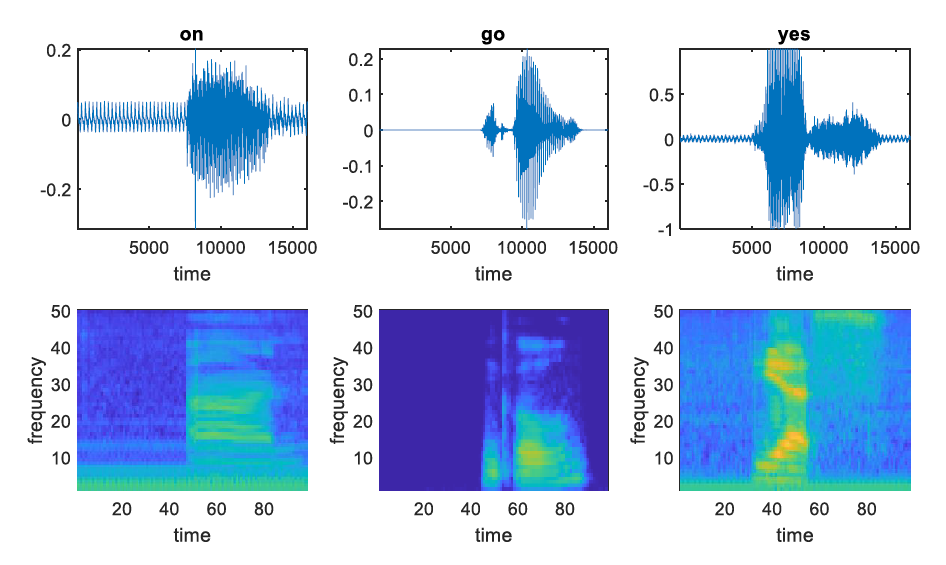

**Figure 1.** Examples of speech waveforms in the time-domain (top) and corresponding speech image
spectrogram that forms the input data (bottom). The spoken word is given in the title and forms the class
label output: ‘on’, ‘go’ and ‘yes’.

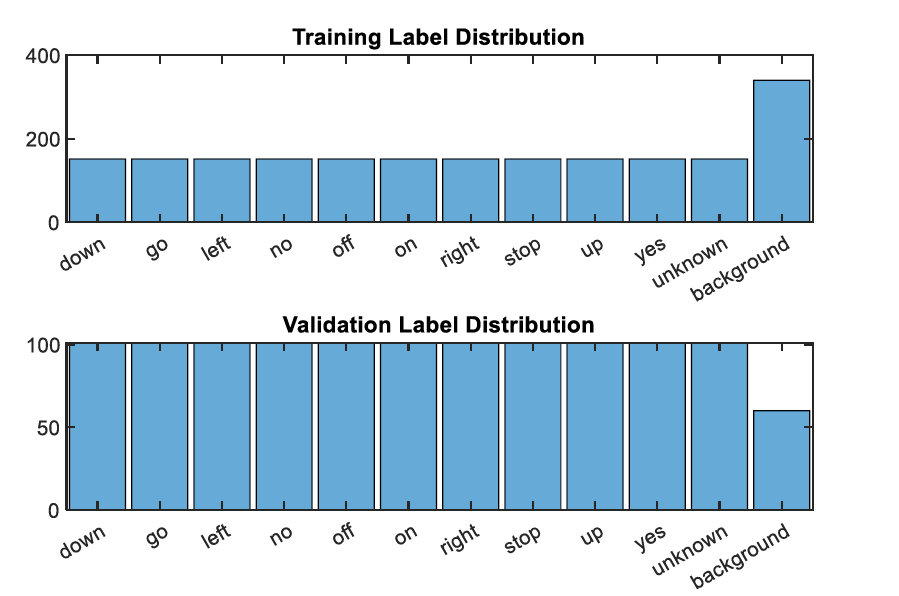


**Figure 2.** The initial training and validation data has the distribution shown in the plots, i.e. 12 words
(therefore 12 classes) and nearly 200 training data pairs per word and 100 validation data pairs per word.


# Libraries and Helpers


## General Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix     
import seaborn as sns      
from keras.models import Sequential                               
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D, Flatten, Softmax, SeparableConv2D      
from keras import optimizers, regularizers 

## Helper Functions

### Install Package

In [2]:

import importlib.util
import subprocess

# Install a package if it is not already installed
def install_package(name):
  spec = importlib.util.find_spec(name)
  if spec is None:
    print(f"installing {name} module")
    subprocess.check_call(['pip', 'install', name])
  else:
    print(f"{name} already installed")

### Inception Layer

The Inception module consists of four parallel layers:

1. A 1x1 convolutional layer
2. A 3x3 convolutional layer, preceded by a 1x1 convolutional layer for dimensionality reduction
3. A 5x5 convolutional layer, preceded by a 1x1 convolutional layer for dimensionality reduction
4. A 3x3 max pooling layer, followed by a 1x1 convolutional layer

The outputs of these four parallel layers are concatenated along the channel axis to form the output of the Inception module.

In [3]:
from keras.layers import Conv2D, MaxPooling2D, concatenate

# Function to create an Inception module for a neural network
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 convolutional layer
    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(layer_in)
    
    # 3x3 convolutional layer, preceded by a 1x1 convolutional layer for dimensionality reduction
    conv3 = Conv2D(f2_in, (1, 1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3, 3), padding='same', activation='relu')(conv3)
    
    # 5x5 convolutional layer, preceded by a 1x1 convolutional layer for dimensionality reduction
    conv5 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5, 5), padding='same', activation='relu')(conv5)
    
    # 3x3 max pooling layer, followed by a 1x1 convolutional layer
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1, 1), padding='same', activation='relu')(pool)
    
    # Concatenate the outputs of the four parallel layers (channels last)
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    
    return layer_out


### Create Alternating Convolution model


1x1 Convolution and Depthwise separable convolution layers are used alternatively to reduce the complexity.


Note that the network design has convolutional blocks:

Conv --> Batch norm --> ReLU

and a max pooling layer is used for dimension reduction

In [4]:
def create_alternating_conv_model(num_layers, num_filters, input_shape, num_classes=12): 
  time_pool_size = 12

  model = Sequential() 
  model.add(Input(shape=input_shape))

  for i in range(num_layers): 
    if i % 2 == 0:
      # Depthwise separable convolution
      model.add(SeparableConv2D(num_filters, kernel_size =(3, 3), padding='same', activation='relu'))
    else:
      # 1x1 convolution
      model.add(Conv2D(num_filters/4, kernel_size =(1, 1), padding='same', activation='relu'))
      model.add(Conv2D(num_filters, kernel_size =(3,3), padding='same', activation='relu'))

    model.add(BatchNormalization())

    if i != num_layers-1:
      model.add(MaxPooling2D(pool_size =(3, 3), strides=(2, 2), padding= 'same'))
      model.add(Dropout(0.1))

  model.add(MaxPooling2D(pool_size =(time_pool_size, 1), strides=(1, 1), padding= 'same'))
  model.add(Dropout(0.1))

  model.add(Flatten())

  model.add(Dense(num_classes))
  model.add(Dropout(0.2))
  model.add(Softmax())

  opt = optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
  return model

### Create Inception model

Inception modules are used in this model

In [5]:
from keras.models import Model
from keras.optimizers import Adam

def create_inception_model(input_shape, num_classes=12, num_filters=192):
    inputs = Input(shape=input_shape)

    # Add 4 Inception modules followed by MaxPooling2D layers
    x = inception_module(inputs, num_filters, num_filters//4, num_filters//2, num_filters//8, num_filters//4, num_filters//4)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = inception_module(x, num_filters, num_filters//4, num_filters//2, num_filters//8, num_filters//4, num_filters//4)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = inception_module(x, num_filters, num_filters//4, num_filters//2, num_filters//8, num_filters//4, num_filters//4)
    x = BatchNormalization()(x)

    x = inception_module(x, num_filters, num_filters//4, num_filters//2, num_filters//8, num_filters//4, num_filters//4)
    x = BatchNormalization()(x)
    
    # Final MaxPooling2D layer before Dense layers
    x = MaxPooling2D(pool_size=(12, 1), strides=(1, 1), padding='same')(x)
    x = Dropout(0.1)(x)

    # Flatten and add Dense layers
    x = Flatten()(x)
    x = Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.2)(x)
    outputs = Softmax()(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    opt = Adam(learning_rate=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


### Create Googlenet Model

In [6]:
from keras.layers import AveragePooling2D

def create_googlenet(input_shape, num_classes=12):
  inputs = Input(shape=input_shape)

  x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
  x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = inception_module(x, 64, 96, 128, 16, 32, 32)
  x = inception_module(x, 128, 128, 192, 32, 96, 64)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = inception_module(x, 192, 96, 208, 16, 48, 64)
  x = inception_module(x, 160, 112, 224, 24, 64, 64)
  x = inception_module(x, 128, 128, 256, 24, 64, 64)
  x = inception_module(x, 112, 144, 288, 32, 64, 64)
  x = inception_module(x, 256, 160, 320, 32, 128, 128)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = inception_module(x, 256, 160, 320, 32, 128, 128)
  x = inception_module(x, 384, 192, 384, 48, 128, 128)

  x = AveragePooling2D((4, 2), strides=(1, 1), padding='valid')(x)  # Adjusted pool size to fit input shape (98, 50, 1)
  x = Dropout(0.4)(x)

  x = Flatten()(x)
  x = Dense(num_classes, activation='linear')(x)
  outputs = Softmax()(x)

  # Create and compile the model
  model = Model(inputs=inputs, outputs=outputs)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

### Create Modified Googlenet Model

In [ ]:
from keras.layers import AveragePooling2D

def create_googlenet_modified(input_shape, num_classes=12):
  inputs = Input(shape=input_shape)

  x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
  x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = inception_module(x, 64, 96, 128, 16, 32, 32)
  x = inception_module(x, 128, 128, 192, 32, 96, 64)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = inception_module(x, 192, 96, 208, 16, 48, 64)
  x = inception_module(x, 160, 112, 224, 24, 64, 64)
  x = inception_module(x, 128, 128, 256, 24, 64, 64)
  x = inception_module(x, 112, 144, 288, 32, 64, 64)
  x = inception_module(x, 256, 160, 320, 32, 128, 128)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.2)(x)

  x = inception_module(x, 256, 160, 320, 32, 128, 128)
  x = inception_module(x, 384, 192, 384, 48, 128, 128)

  x = AveragePooling2D((4, 2), strides=(1, 1), padding='valid')(x)  # Adjusted pool size to fit input shape (98, 50, 1)
  x = Dropout(0.4)(x)

  x = Flatten()(x)
  x = Dense(num_classes, activation='linear')(x)
  x = Dropout(0.2)(x)
  outputs = Softmax()(x)

  # Create and compile the model
  model = Model(inputs=inputs, outputs=outputs)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

### Plot Learning curve

Plot accuracy and loss over training epochs (for both training data and validation data) - it is important to monitor convergence of the algorithm via these plots to assess whether the parameter estimation has converged.

In [7]:

def plot_learning_curve(history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  print("")

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### Train Bagging Ensemble Model

In [8]:
def train_bagging_model(bagging_model, x_train, y_train, batch_size, epochs, validation_split):
  n_samples = x_train.shape[0]

  for i,model in enumerate(bagging_model, start=1):
    print(f'******* MODEL {i} *******\n\n')
    
    # Sampling with replacement
    indices = np.random.choice(n_samples, n_samples, replace=True)
    x_train_bagging = tf.gather(x_train, indices)
    y_train_bagging = tf.gather(y_train, indices)

    # Calculate and print the percentage of unique samples
    unique_indices = np.unique(indices)
    unique_percentage = (len(unique_indices) / n_samples) * 100
    print(f'Percentage of unique samples: {unique_percentage:.2f}%\n')

    history = model.fit(x_train_bagging, y_train_bagging, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    plot_learning_curve(history)

### Evaluate Model

In [9]:
# print out the accuracy on independent test data
def evaluate_model(model, x_val, y_val):
  score = model.evaluate(x_val, y_val, verbose=0)
  print("Test accuracy:", score[1])

### Evaluate Bagging Ensemble Member Models

In [10]:
def evaluate_bagging_member_models(bagging_model, x_val, y_val):
  for i, model in enumerate(bagging_model, start=1):
    print(f'******* MODEL {i} *******\n\n')
    evaluate_model(model, x_val, y_val)

### Evaluate Bagging Ensemble Model

Voting implementation:
1. predict with each trained model
2. take the majority class prediction
3. evaluate the prediction accuracy
4. benchmark/compare to a single model and see if the accuracy is better

In [11]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

def evaluate_bagging_model(bagging_model, x_val, y_val):
  member_Yhats = []

  for i, model in enumerate(bagging_model, start=1):  
    Yhat = model.predict(x_val)                    # predict model outputs on validation data as softmax outputs of probability of each class
    Yhat_integer = np.argmax(Yhat, axis=1)         # obtain the most likely class prediction as the argument of the max softmax output
    # Add to the Yhats list
    member_Yhats.append(Yhat_integer)

  member_Yhats = np.array(member_Yhats)
  Yhat = mode(member_Yhats, keepdims=True)[0][0]
  
  Y_test_integer = np.argmax(y_val, axis=1)        # obtain the true class as an integer 

  accuracy = accuracy_score(Y_test_integer, Yhat)

  print(f'Test accuracy of the bagging model: {accuracy}')
  

### Plot Bagging Ensemble Confusion Matrix

In [12]:
# obtain model predictions and convert softmax outputs 0-1 to integer class label predictions
def plot_bagging_confusion_matrix(bagging_model, x_val, y_val, train_ds):
  member_Yhats = []

  for i, model in enumerate(bagging_model, start=1):  
    Yhat = model.predict(x_val)                    # predict model outputs on validation data as softmax outputs of probability of each class
    Yhat_integer = np.argmax(Yhat, axis=1)         # obtain the most likely class prediction as the argument of the max softmax output
    # Add to the Yhats list
    member_Yhats.append(Yhat_integer)

  member_Yhats = np.array(member_Yhats)
  Yhat = mode(member_Yhats, keepdims=True)[0][0]
  
  Y_test_integer = np.argmax(y_val, axis=1)        # obtain the true class as an integer 

  class_labels = np.array(train_ds.class_names)

  # calculate and plot confusion matrix
  cm = confusion_matrix(Y_test_integer, Yhat_integer, normalize="pred")    # calculate the confusion matrix

  plt.figure(2).set_figwidth(15)                                            # setup new figure

  sns.heatmap(cm/np.sum(cm), 
              annot=True, fmt=".2%", 
              cmap="Blues", 
              yticklabels=class_labels, 
              xticklabels=class_labels)          # plot the confusion matrix using the sns package
              
  plt.title("Confusion Matrix", fontsize = 12)                              # title
  plt.xlabel("Predicted Class", fontsize = 12)                              # xlabel
  plt.ylabel("True Class", fontsize = 12)                                   # ylabel
  plt.show()     

### Plot Confusion Matrix

In [13]:
# obtain model predictions and convert softmax outputs 0-1 to integer class label predictions
def plot_confusion_matrix(model, x_val, y_val, train_ds):
  Yhat = model.predict(x_val)                    # predict model outputs on validation data as softmax outputs of probability of each class
  Yhat_integer = np.argmax(Yhat, axis=1)            # obtain the most likely class prediction as the argument of the max softmax output
  Y_test_integer = np.argmax(y_val, axis=1)   # obtain the true class as an integer 

  class_labels = np.array(train_ds.class_names)

  # calculate and plot confusion matrix
  cm = confusion_matrix(Y_test_integer, Yhat_integer, normalize="pred")    # calculate the confusion matrix

  plt.figure(2).set_figwidth(15)                                            # setup new figure

  sns.heatmap(cm/np.sum(cm), 
              annot=True, fmt=".2%", 
              cmap="Blues", 
              yticklabels=class_labels, 
              xticklabels=class_labels)          # plot the confusion matrix using the sns package
              
  plt.title("Confusion Matrix", fontsize = 12)                              # title
  plt.xlabel("Predicted Class", fontsize = 12)                              # xlabel
  plt.ylabel("True Class", fontsize = 12)                                   # ylabel
  plt.show()     

#  <> Pre-process the data

The code does the following:

*   Load the data
*   Creates Keras training and validation datasets
*   Extracts input-output data from the Keras datasets
*   Normalise the image data

## Load the data


  *   Pulls the data in from github
  *   Unzips the data

This is done only if the target folder doesn't exist already. When re-running the entire code, this check ensures that no duplicate folder is created.


In [14]:
import tensorflow as tf
import os.path

path = '/content/speechImageData - Copy/TrainData'

if(not os.path.isdir(path)):
  print('Getting data from github and unzipping...')

  # get the data from github and unzip
  !wget https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
  !unzip -q /content/speechImageData.zip

else:
  print("Unzipped folder already exists! (speechImageData - Copy)")


Unzipped folder already exists! (speechImageData - Copy)


## Pre-process data into training and validation sets, using Keras dataset objects

Note that when the data is unzipped it is stored locally to Google Colab in the content folder and the unzipped folder is called 

'speechImageData - Copy'

and it contains: 

the training data in the folder TrainData and 

the validation in the folder ValData

There are 12 classes of different spoken words and the spectrograms, which form the input image data are of size 98x50 pixels.

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/speechImageData - Copy/TrainData', 
    labels='inferred', 
    color_mode="grayscale", 
    label_mode='categorical', 
    batch_size=128, 
    image_size=(98, 50)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/speechImageData - Copy/ValData', 
    labels='inferred', 
    color_mode="grayscale", 
    label_mode='categorical', 
    batch_size=128, 
    image_size=(98, 50)
)

# Save the number of classes
num_classes = len(train_ds.class_names)

Found 2001 files belonging to 12 classes.
Found 1171 files belonging to 12 classes.


## Extract input-output data, which can be useful for plotting confusion matrices etc.

In [16]:
# Extract the  training input images and output class labels
x_train = []
y_train = []
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

print(y_train)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val = tf.concat(x_val, axis=0)
y_val = tf.concat(y_val, axis=0)

print(y_val)



tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(2001, 12), dtype=float32)
tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]], shape=(1171, 12), dtype=float32)


## Normalise the image data

In [17]:
# Divide by 255 to normalise the data

x_train = x_train/255.0
x_val = x_val/255.0

# <> Model

Requirement: Implement model averaging

## 1. Create the model

In [18]:
input_shape = (98,50,1)
  
model = create_googlenet_modified(input_shape, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 98, 50, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 49, 25, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 13, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 13, 64)  256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

## 2. Model details

### 2.1. Keras Plot Model

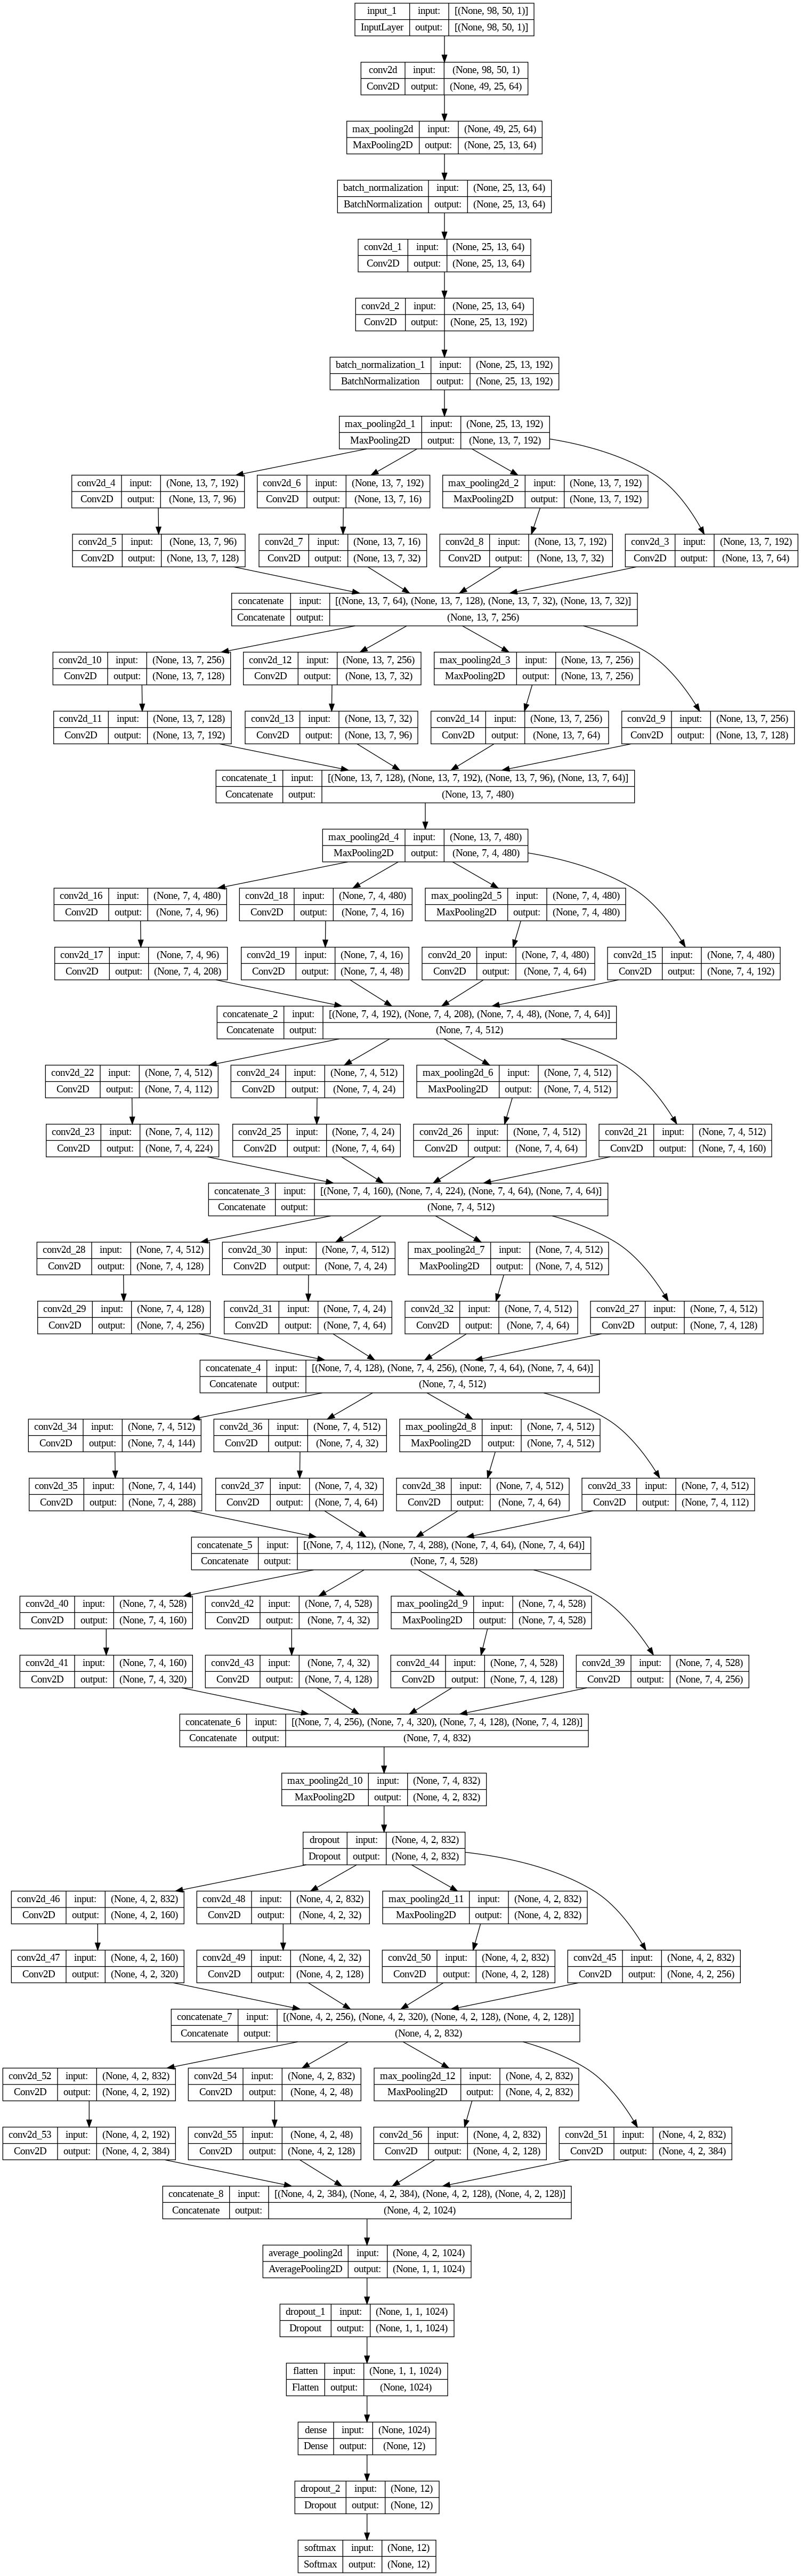

In [19]:
#@title
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### 2.2. Visual Keras

In [20]:
# Install visualkeras & import
install_package('visualkeras')

visualkeras already installed


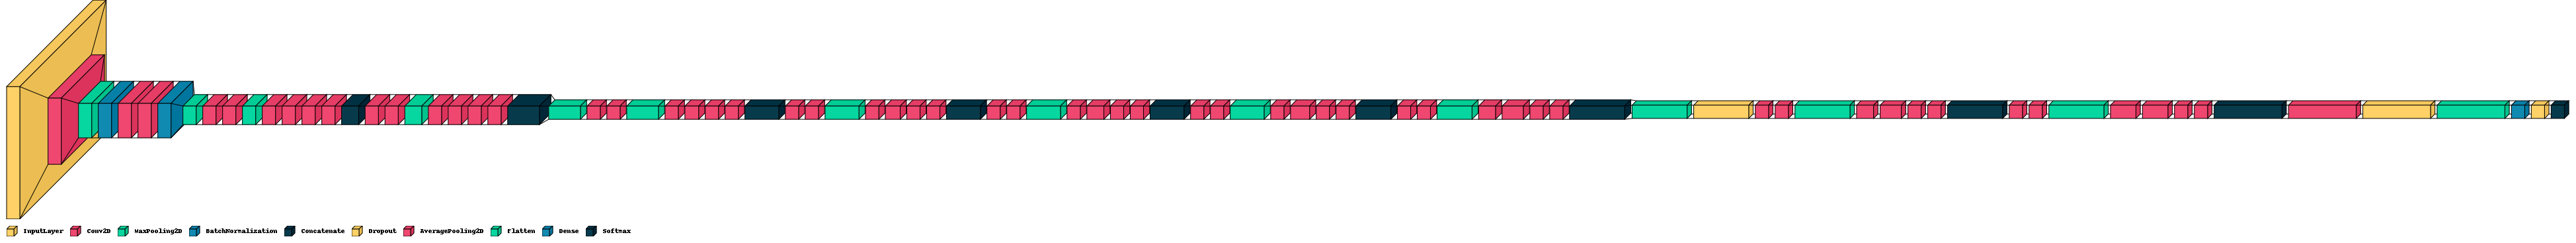

In [21]:
#@title
import visualkeras
visualkeras.layered_view(model, legend=True)

## 3. Train the bagging model

This section trains the bagging model

### 3.1 Train

In [22]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [early_stopping]

history = model.fit(x_train, y_train, batch_size=32, epochs=60, validation_split=0.1, callbacks=callbacks)

Epoch 1/60
57/57 [==============================] - 45s 107ms/step - loss: 2.3342 - accuracy: 0.1728 - val_loss: 2.4119 - val_accuracy: 0.1741
Epoch 2/60
57/57 [==============================] - 2s 27ms/step - loss: 2.1291 - accuracy: 0.2283 - val_loss: 6.3422 - val_accuracy: 0.1741
Epoch 3/60
57/57 [==============================] - 2s 27ms/step - loss: 2.1862 - accuracy: 0.2156 - val_loss: 4.1087 - val_accuracy: 0.1741
Epoch 4/60
57/57 [==============================] - 2s 28ms/step - loss: 2.0919 - accuracy: 0.2339 - val_loss: 8.0903 - val_accuracy: 0.1741
Epoch 5/60
57/57 [==============================] - 2s 28ms/step - loss: 2.0594 - accuracy: 0.2422 - val_loss: 8.7746 - val_accuracy: 0.1741
Epoch 6/60
57/57 [==============================] - 2s 27ms/step - loss: 2.0741 - accuracy: 0.2550 - val_loss: 3.1584 - val_accuracy: 0.2189
Epoch 7/60
57/57 [==============================] - 2s 33ms/step - loss: 2.0517 - accuracy: 0.2661 - val_loss: 3.7102 - val_accuracy: 0.1841
Epoch 8/60


## 4. Evaluate the model

### 4.2. Print out the accuracy on the Validation Data


In [23]:
# print out the accuracy on independent test data
score = model.evaluate(x_val, y_val, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.7079419493675232


### 4.1. Plot accuracy and loss over training iterations

Plot accuracy and loss over training epochs (for both training data and validation data) - it is important to monitor convergence of the algorithm via these plots to assess whether the parameter estimation has converged.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


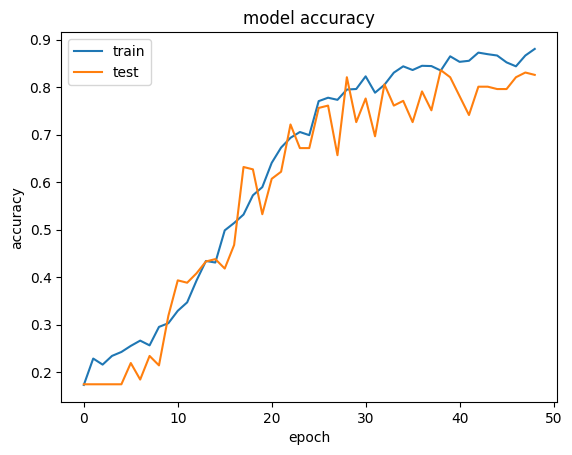

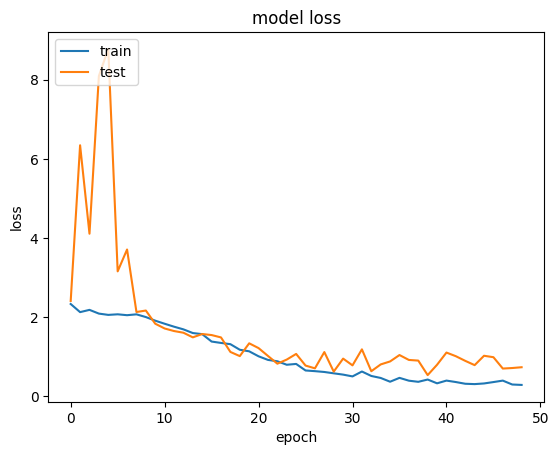

In [24]:
plot_learning_curve(history)

### 4.3. Confusion matrix

Calculate and display the confusion matrix for this problem - the confusion matrix is important to inspect because it gives more insight into classifier performance across all classes than simply inspecting accuracy, which obscures detail.

37/37 [==============================] - 1s 7ms/step


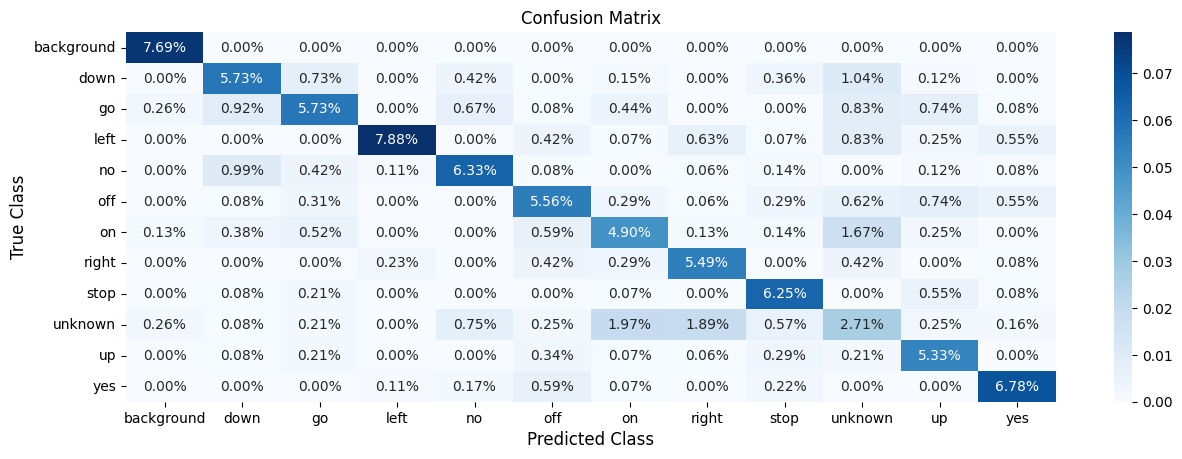

In [25]:
plot_confusion_matrix(model, x_val, y_val, train_ds)